In [429]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import geopandas as gpd
from pandas.core.internals.concat import concat_arrays
from shapely.geometry import Point
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic
#todos los imports
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


In [255]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Obtengamos las columnas que tienen valores vacíos y la cantidad de nulos por cada columna

In [257]:
na_columns = df.columns[df.isna().any()].tolist()
na_total = df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total
0,ALC_mg/L,4
1,CALIDAD_ALC,4
2,CONDUCT_mS/cm,6
3,CALIDAD_CONDUC,6
4,SDT_mg/L,1068
5,SDT_M_mg/L,2
6,CALIDAD_SDT_ra,2
7,CALIDAD_SDT_salin,2
8,DUR_mg/L,1
9,CALIDAD_DUR,1


De la tabla anterior se puede apreciar que la columna de Solidos Totales Disueltos (SDT_mg/L) está completamente vacía. La segunda columna con mayor cantidad de nulos es Contaminantes, sin embargo, esta es de esperarse puesto que hay mediciones de agua que no arrojan contaminantes. En otras palabras, un valor nulo en esta columna equivale a ausencia de contaminantes en el agua.

Las demás columnas presentan pocas observaciones nulas. Más adelante definiremos una estrategia para de imputación para estas columnas con valores faltantes.

Del resultado anterior se observa columnas que contienen la misma información pero en tipo de datos diferentes. También hay columnas numéricas detectadas como tipo "object". Vamos a extraer primero todas las columnas categóricas y binarias, ya que son candidatas a ser eliminadas.

In [258]:
#Obtenemos las columnas binarias o categóricas ya que tienen información repetida. Estas son candidatas a eliminarse
cols_to_drop  = df.columns[df.columns.str.contains('CALIDAD|CUMPLE')].to_list()
cols_to_drop


['CALIDAD_ALC',
 'CALIDAD_CONDUC',
 'CALIDAD_SDT_ra',
 'CALIDAD_SDT_salin',
 'CALIDAD_FLUO',
 'CALIDAD_DUR',
 'CALIDAD_COLI_FEC',
 'CALIDAD_N_NO3',
 'CALIDAD_AS',
 'CALIDAD_CD',
 'CALIDAD_CR',
 'CALIDAD_HG',
 'CALIDAD_PB',
 'CALIDAD_MN',
 'CALIDAD_FE',
 'CUMPLE_CON_ALC',
 'CUMPLE_CON_COND',
 'CUMPLE_CON_SDT_ra',
 'CUMPLE_CON_SDT_salin',
 'CUMPLE_CON_FLUO',
 'CUMPLE_CON_DUR',
 'CUMPLE_CON_CF',
 'CUMPLE_CON_NO3',
 'CUMPLE_CON_AS',
 'CUMPLE_CON_CD',
 'CUMPLE_CON_CR',
 'CUMPLE_CON_HG',
 'CUMPLE_CON_PB',
 'CUMPLE_CON_MN',
 'CUMPLE_CON_FE']

Ahora revisemos una de las columnas numéricas que fueron detectadas como object. Tomaremos un ejemplo con Cadmio (CD_TOT_mg/L)

In [259]:
df['CD_TOT_mg/L'].value_counts()

<0.003     1066
0.0056        1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se observa que valores muy pequeños son colocados como "<". Para ello, vamos a reemplazar este string por un valor arbitrario por debajo del umbral, de manera que podamos crear una cota inferior y así analizarlo por medio de un histograma o boxplot.

In [260]:
#Definimos las variables numéricas a analizar
vars = [
        'ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L',
        'SDT_mg/L', 'FLUORUROS_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 
        'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L' ]

limits = {}
for  var in vars:
        if  (df[var].dtypes == 'object'):
                #Obtenemos las observaciones que solo tengan < > o =
                limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
#Lo convertimos en DF para mejor visualización
limits_df = pd.DataFrame(limits, index = [0])
display(limits_df.style.hide(axis = 'index'))

AS_TOT_mg/L,CD_TOT_mg/L,FE_TOT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L,COLI_FEC_NMP/100_mL,CR_TOT_mg/L,DUR_mg/L,HG_TOT_mg/L,MN_TOT_mg/L,N_NO3_mg/L,PB_TOT_mg/L
<0.01,<0.003,<0.025,<25,<0.2,<1.1,<0.005,<20,<0.0005,<0.0015,<0.02,<0.005


Se observan que 12 variables tienen valores string. Vamos a proceder sustituir estos strings por valores numéricos.

In [261]:
#Extraemos las columnas que deben ser convertidas de object a float
columns = limits_df.columns

#Hacemos un transpose para que la tabla tenga dos columnas, una con los atributos químicos y otra con sus valores
limits_df = limits_df.transpose()
limits_df = limits_df.reset_index(level = 0)
limits_df.rename(columns={'index': 'attributes', 0:'attr_values'}, inplace= True)

#Extraemos los valores numéricos, eliminando cualquier string (por ej. '<')
limits_df.attr_values = limits_df.attr_values.str.extract('(\d+\.\d+|\d+)')

display(limits_df)
   
   

,attributes,attr_values
0,AS_TOT_mg/L,0.01
1,CD_TOT_mg/L,0.003
2,FE_TOT_mg/L,0.025
3,SDT_M_mg/L,25
4,FLUORUROS_mg/L,0.2
5,COLI_FEC_NMP/100_mL,1.1
6,CR_TOT_mg/L,0.005
7,DUR_mg/L,20
8,HG_TOT_mg/L,0.0005
9,MN_TOT_mg/L,0.0015


In [262]:
#Sustituimos los valores string por un valor float arbitrario, que se encuentre por debajo de lo indicado por la columna
for col in columns:
   val =  (limits_df.loc[limits_df.attributes == col].attr_values.values[0])
   str_match = '<'+ val
   val = float(val)

   df.loc[df[col] == str_match, col] = val -(val/10)
   
   #Convertimos la columna a tipo float
   df[col] = df[col].astype(float)

In [263]:
#Probamos la conversión con una de las columnas
df[['FE_TOT_mg/L']].sort_values(by = 'FE_TOT_mg/L', ascending = False)

,FE_TOT_mg/L
425,178.6150
331,16.4371
9,14.0600
799,13.4400
561,7.3820
...,...
675,0.0225
672,0.0225
671,0.0225
670,0.0225


In [264]:
uniques = {'attributes': [], 'unique_vals': []}
for col in vars:
    uniques['attributes'].append(col) 
    uniques['unique_vals'].append(df[col].unique().size)
    
pd.DataFrame(uniques)

,attributes,unique_vals
0,ALC_mg/L,817
1,AS_TOT_mg/L,209
2,CD_TOT_mg/L,3
3,FE_TOT_mg/L,615
4,SDT_M_mg/L,926
5,SDT_mg/L,1
6,FLUORUROS_mg/L,862
7,COLI_FEC_NMP/100_mL,125
8,CONDUCT_mS/cm,802
9,CR_TOT_mg/L,168


De la tabla anterior, el atributo Solidos Disueltos Totales (SDT_mg/L) está completamente vacío y por eso aparece que tiene solo un valor único, como veremos más adelante. En el caso de Cadmio (CD_TOT), este tiene apenas 3 valores únicos. Revisemos cuáles son estos valores.

In [265]:
df['CD_TOT_mg/L'].value_counts()

0.00270    1066
0.00560       1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se puede apreciar que casi el 100% de las observaciones caen dentro del rango aceptable (<0.003), mientras que los otros dos valores no cumplen con el parámetro requerido (>0.005). Esto significa que podríamos perfectamente usar la variable binaria correspondiente a este atributo, ya que la información proporcionada es exactamente la misma.

Ahora revisemos la correlación entre cada una de las variables del conjunto de datos.

<AxesSubplot: >

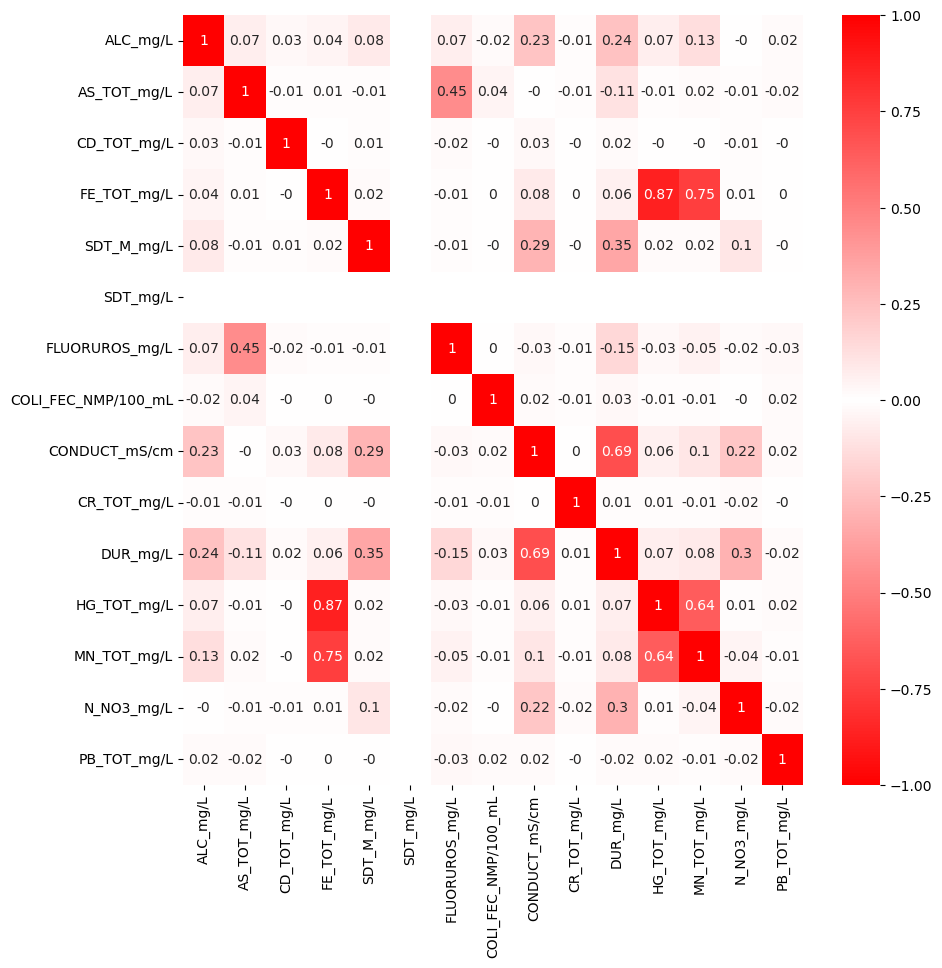

In [266]:
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','red'])
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df[vars].corr(), 2), annot=True, cmap = cmap, vmin = -1.0, vmax = 1.0)

Para realizar el análisis de correlación, usaremos como umbral para definir correlación fuerte aquellas variables que tengan un coeficiente >= 0.75. Basado en este criterio, podemos observar que tres variables están altamente correlacionadas:

* Mercurio (HG)
* Manganeso (MN)
* Hierro (FE)

In [267]:
df[['HG_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']].isna().any()

HG_TOT_mg/L    False
MN_TOT_mg/L    False
FE_TOT_mg/L    False
dtype: bool

Ahora revisemos los campos vacíos de las demás variables que no tienen una correlación alta, basada en el criterio definido arriba

In [268]:
na_columns = df.columns[df.isna().any()].tolist()
na_total = df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total
0,ALC_mg/L,4
1,CALIDAD_ALC,4
2,CONDUCT_mS/cm,6
3,CALIDAD_CONDUC,6
4,SDT_mg/L,1068
5,SDT_M_mg/L,2
6,CALIDAD_SDT_ra,2
7,CALIDAD_SDT_salin,2
8,DUR_mg/L,1
9,CALIDAD_DUR,1


De la tabla anterior se aprecia que ninguna de las variables altamente correlacionadas cuentan con campos vacíos. También se puede observar que variables con una correlación relativamente alta, como Conductividad y Dureza (coef = 0.69), cuentan con campos vacíos. Para estas dos variables podríamos apoyarnos de la información de la correlación para definir una estrategia de imputación.

En el caso de la variable "SDT_mg/L", esta se encuentra completamente vacía, sin embargo, esta tiene una relación directa con la conductividad del agua, donde puede ser calculada con la siguiente fórmula: (https://iwaponline.com/wst/article/77/8/1998/38602/Relationship-between-total-dissolved-solids-and):

TDS (mg/L) = Ke x EC(uS/cm)

donde Ke es un factor que normalmente varía entre 0.55 a 0.85 y EC es la conductividad del agua.

Como la relación de los sólidos totales disueltos es directamente proporcional a la conductividad del agua, esta variable puede ser eliminada para fines de entrenar el modelo, ya que estaría altamente correlacionada con la conductividad, y por ende proporcionar la misma información para el modelo.

Por otro lado, la segunda columna con mayor cantidad de nulos es Contaminantes, sin embargo, esta es de esperarse puesto que hay mediciones de agua que no arrojan contaminantes. En otras palabras, un valor nulo en esta columna equivale a ausencia de contaminantes en el agua.

Las demás columnas presentan pocas observaciones nulas.

**Conclusiones de esta sección**

De esta sección concluimos lo siguiente:

1. Las columnas de Mercurio, Manganeso están altamente correlacionadas con Hierro, por lo que podemos eliminar dos de ellas. Para este caso, nos quedaremos solamente con la columna de Hierro.
2. La variable "SDT_mg/L" tiene todos los campos vacíos, sin embargo, este valor es directamente proporcional a la conductividad. En este sentido, podemos eliminar esta columna ya que estaría altamente correlacionada con la conductividad.
3. La variable "Contaminantes" puede ser eliminada, ya que esto solo indica los contaminantes cuando el agua no es apta para su uso. Esta información no agregaría valor al modelo.
4. La variable "CD_TOT" solo tiene dos valores únicos, por lo que puede eliminarse y reemplazarse en su lugar por su variable binaria correspondiente (CUMPLE_CON_CD).
5. Las demás variables binarias y categóricas pueden ser eliminadas ya que se estarán utilizando las variables numéricas en su lugar.


En la próxima sesión definiremos la estrategia de imputación.

### **II. Estrategia de Imputación**

En esta sección definiremos la mejor manera de imputar los datos vacíos y nulos. Para ello comencemos primero con las variables "Conductividad" y "Dureza", las cuales mostraron una correlación relativamente alta en la sección anterior.

Comencemos primero revisando que porcentaje de las variables "CUMPLE_CON_COND" y "CUMPLE_CON_DUR" coincide en sus valores. Debido a la correlación de 0.69 obtenida en la sección anterior, es de esperarse que un alto porcentaje coincida.

In [269]:
#Al existir una alta correlación entre conductividad y dureza, las columnas de cumplimiento coinciden en casi el 85% de las veces. Se podría imputar una de estas columna con el valor correspondiente de la otra
len(df[df['CUMPLE_CON_COND'] == df['CUMPLE_CON_DUR']])/len(df)

0.849250936329588

Cerca de 85% de las observaciones tienen valores iguales entre las columnas de "CUMPLE_CON_COND" y "CUMPLE_CON_DUR", como era de esperarse. Esta información podemos usarla para definir una estrategia de imputación personalizada, tanto para dureza como conductividad.

In [329]:
class HardnessImputer (TransformerMixin, BaseEstimator):
    
    def __transformHardness(self, X):
               
        X.loc[(X['DUR_mg/L'].isna()) & (X['CUMPLE_CON_COND'] == 'SI'),'DUR_mg/L'] = \
            X[X['CUMPLE_CON_COND'] == 'SI']['DUR_mg/L'].median()
            
        X.loc[(X['DUR_mg/L'].isna()) & (X['CUMPLE_CON_COND'] == 'NO'),'DUR_mg/L'] = \
            X[X['CUMPLE_CON_COND'] == 'NO']['DUR_mg/L'].median()
        
        return X
        
    def __transformConductivity(self, X):
                
        X.loc[(X['CONDUCT_mS/cm'].isna()) & (X['CUMPLE_CON_DUR'] == 'SI'),'CONDUCT_mS/cm'] = \
            X[X['CUMPLE_CON_DUR'] == 'SI']['CONDUCT_mS/cm'].median()
            
        X.loc[(X['CONDUCT_mS/cm'].isna()) & (X['CUMPLE_CON_DUR'] == 'NO'),'CONDUCT_mS/cm'] = \
            X[X['CUMPLE_CON_DUR'] == 'NO']['CONDUCT_mS/cm'].median()
        
        return X
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X_copy = X.copy()
        
        X_copy = self.__transformHardness(X_copy)
        X_copy = self.__transformConductivity(X_copy)
        
        X_copy = X_copy.drop(['CUMPLE_CON_DUR', 'CUMPLE_CON_COND'], axis = 1)
        
        X_copy = X_copy.fillna(X_copy.median())
        
        return X_copy
        
        #return X_copy[['CONDUCT_mS/cm', 'DUR_mg/L']]
        
        # X_copy = X.copy()
               
        # X_copy.loc[(X_copy['DUR_mg/L'].isna()) & (X_copy['CUMPLE_CON_COND'] == 'SI'),'DUR_mg/L'] = \
        #     X_copy[X_copy['CUMPLE_CON_COND'] == 'SI']['DUR_mg/L'].median()
            
        # X_copy.loc[(X_copy['DUR_mg/L'].isna()) & (X_copy['CUMPLE_CON_COND'] == 'NO'),'DUR_mg/L'] = \
        #     X_copy[X_copy['CUMPLE_CON_COND'] == 'NO']['DUR_mg/L'].median()
        
        # return X_copy


class ConductivityImputer (TransformerMixin, BaseEstimator):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_copy = X.copy()
                
        X_copy.loc[(X_copy['CONDUCT_mS/cm'].isna()) & (X_copy['CUMPLE_CON_DUR'] == 'SI'),'CONDUCT_mS/cm'] = \
            X_copy[X_copy['CUMPLE_CON_DUR'] == 'SI']['CONDUCT_mS/cm'].median()
            
        X_copy.loc[(X_copy['CONDUCT_mS/cm'].isna()) & (X_copy['CUMPLE_CON_DUR'] == 'NO'),'CONDUCT_mS/cm'] = \
            X_copy[X_copy['CUMPLE_CON_DUR'] == 'NO']['CONDUCT_mS/cm'].median()
        
        return X_copy

Probemos que los imputadores funcionan

In [271]:
impt = ConductivityImputer()


res = impt.transform(df)

res['CONDUCT_mS/cm'].isna().sum()

0

In [272]:
impt = HardnessImputer()

res = impt.transform(df)

res['DUR_mg/L'].isna().sum()

0

Ahora procederemos a definir las columnas que estaremos eliminado, como concluímos en la sección #1.

In [273]:
cols_to_drop  = df.columns[df.columns.str.contains('(?!CUMPLE_CON_CD)(?:CALIDAD|CUMPLE)')].to_list()
cols_to_drop.extend(['CLAVE', 'SITIO', 'CONTAMINANTES', 'ORGANISMO_DE_CUENCA', 'PERIODO', 
                     'CD_TOT_mg/L', 'ACUIFERO', 'MUNICIPIO', 'SDT_mg/L', 'ESTADO'])

In [274]:

X = df.drop(cols_to_drop + ['SEMAFORO'], axis = 1)

In [275]:
X.head()

,SUBTIPO,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L,CUMPLE_CON_CD
0,POZO,-102.02210,22.20887,229.990,940.0,603.6,0.9766,213.7320,0.99,4.184656,0.0161,0.0045,0.00045,0.0045,0.00135,0.0891,SI
1,POZO,-102.20075,21.99958,231.990,608.0,445.4,0.9298,185.0514,0.99,5.750110,0.0134,0.0045,0.00045,0.0045,0.00135,0.0225,SI
2,POZO,-102.28801,22.36685,204.920,532.0,342.0,1.8045,120.7190,0.99,1.449803,0.0370,0.0045,0.00045,0.0045,0.00135,0.0225,SI
3,POZO,-102.29449,22.18435,327.000,686.0,478.6,1.1229,199.8790,0.99,1.258597,0.0154,0.0050,0.00045,0.0045,0.00135,0.0225,SI
4,POZO,-110.24480,23.45138,309.885,1841.0,1179.0,0.2343,476.9872,291.00,15.672251,0.0090,0.0045,0.00045,0.0045,0.00135,0.0225,SI


In [276]:
X.columns

Index(['SUBTIPO', 'LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm',
       'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL',
       'N_NO3_mg/L', 'AS_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L',
       'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L', 'CUMPLE_CON_CD'],
      dtype='object')

In [277]:
y = df[['SEMAFORO']]

In [278]:
y.head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


In [316]:
bin_vars = ['CUMPLE_CON_CD']
cat_vars = ['LONGITUD', 'LATITUD', 'SUBTIPO']
num_vars = X.drop(cat_vars + bin_vars, axis = 1).columns.to_list()

print(f'Numeric variables: {num_vars}\n')
print(f'Categorical variables: {cat_vars}\n')
print(f'Binary variables: {bin_vars}')

Numeric variables: ['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']

Categorical variables: ['LONGITUD', 'LATITUD', 'SUBTIPO']

Binary variables: ['CUMPLE_CON_CD']


In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [281]:
#Para fines del análisis descriptivo, sacamos Longitud y Latitud, ya que estas variables son identificadores
X_train.drop(['LONGITUD', 'LATITUD'], axis = 1).describe()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,850.000000,849.000000,853.000000,854.000000,853.000000,854.000000,853.000000,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,236.897365,1123.704594,906.363154,1.084913,346.316472,381.495492,4.346939,0.018472,0.008283,0.000502,0.004846,0.071407,0.254108
std,117.822711,1270.561738,3048.214139,2.005090,370.847881,2109.616203,8.523581,0.032840,0.023635,0.000234,0.003669,0.280160,1.008718
min,26.640000,50.400000,22.500000,0.180000,18.000000,0.990000,0.018000,0.009000,0.004500,0.000450,0.004500,0.001350,0.022500
25%,164.460000,499.000000,333.800000,0.268775,119.520000,0.990000,0.622853,0.009000,0.004500,0.000450,0.004500,0.001350,0.022500
50%,214.810000,810.000000,540.000000,0.496000,241.462400,0.990000,2.069490,0.009000,0.004500,0.000450,0.004500,0.001350,0.047065
75%,297.000000,1309.000000,905.000000,1.139950,448.429200,20.000000,5.193140,0.009000,0.004500,0.000450,0.004500,0.010500,0.174880
max,1650.000000,18577.000000,82170.000000,34.803300,3810.692200,24196.000000,121.007813,0.378400,0.591000,0.003140,0.080900,3.454800,16.437100


Si bien la mayoría de las variables tienen la misma unidad de medida, sus valores umbrales para definir la calidad del agua son diferentes. Por ejemplo, dureza debe ser menor < 60 mg/L, mientras que los nitratos deben estar por debajo de 5 mg/L y el mercurio por debajo de 0.006 mg/L. Esto significa que sería importante aplicar un escalamiento, para evitar que el modelo a entrenar de más peso a una variable que otra.

Otro aspecto a destacar del análisis descriptivo es la presencia de valores atípicos. Por ejemplo, la dureza tiene un valir máximo de 3,810, cuando su media es de 346 y su mediana de 241.

Hagamos un análisis gráfico de las variables para revisar su distribución y comportamiento.

In [282]:
cols_to_plot = X_train.drop(cat_vars, axis = 1).columns

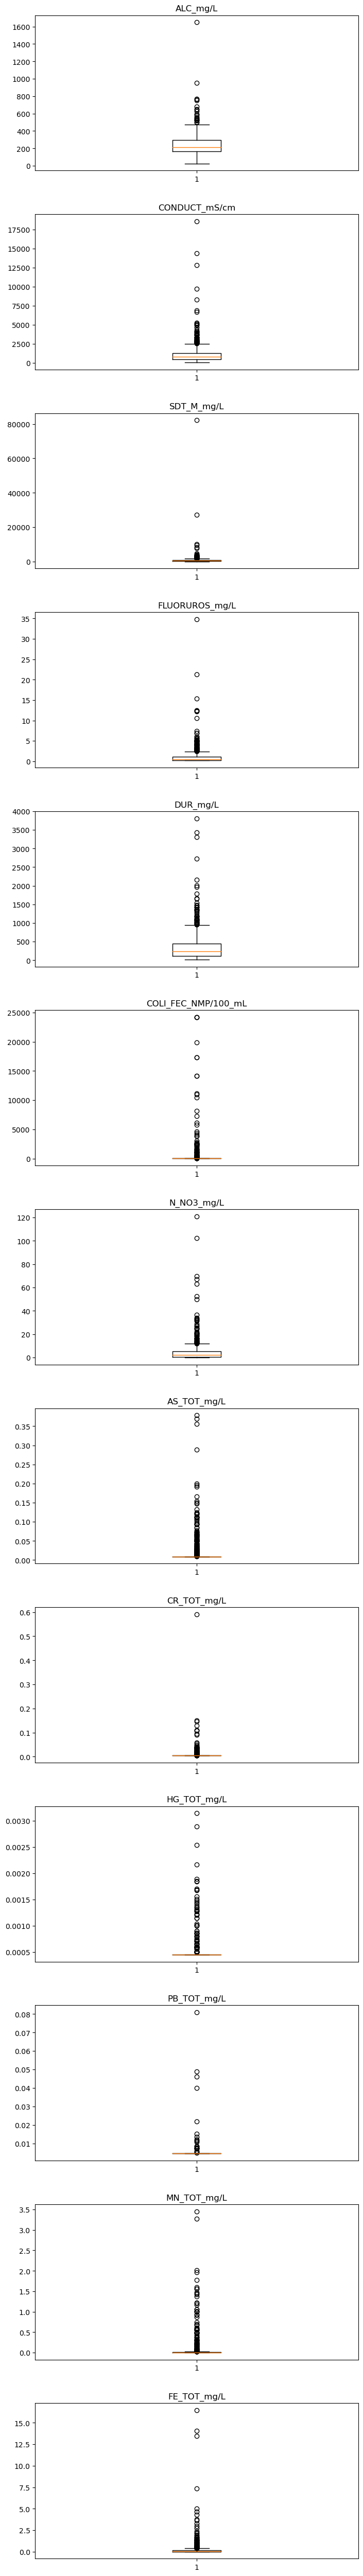

In [283]:
fig, axes = plt.subplots(13)
fig.set_size_inches(7,50)
plt.tight_layout(h_pad = 4)

count = 0

for i in range(13):
        axes[i].boxplot(X_train[num_vars[i]].dropna())
        axes[i].set_title(num_vars[i])
     

De los diagramas de cajas presentados arriba se confirma la presencia de valores atípicos para todas las variables numéricas. Esto representa un problema para el algoritmo K-means, puesto a que es sensible a valores atípicos. Sin embargo, para modelos de clasificación como Árboles de Decisión o Random Forest, la presencia de los atípicos no suponen un problema para estos modelos.



In [300]:
class OutlierImputer(TransformerMixin, BaseEstimator):
       
    min_max_values = {
        'ALC_mg/L': {'min': 19, 'max': 151},
        'COLI_FEC_NMP/100_mL':  {'min': 1.0, 'max': 1001},
        'CONDUCT_mS/cm':  {'min': 249, 'max': 2001},
        'CR_TOT_mg/L':  {'min': 0, 'max': 0.06},
        'DUR_mg/L':  {'min': 60, 'max': 501},
        'FE_TOT_mg/L':  {'min': 0, 'max': 0.4},
        'FLUORUROS_mg/L':  {'min': 0, 'max': 1.5},
        'HG_TOT_mg/L':  {'min': 0, 'max': 0.007},
        'MN_TOT_mg/L':  {'min': 0, 'max': 0.5},
        'N_NO3_mg/L':  {'min': 0, 'max': 12},
        'PB_TOT_mg/L':  {'min': 0, 'max': 0.02},
        'SDT_M_mg/L':  {'min': 0, 'max': 2001},
        'AS_TOT_mg/L':{'min': 0, 'max': 0.026},
        
    }
    def fit (self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        cols = self.min_max_values.keys() #X.drop(['LONGITUD', 'LATITUD'], axis = 1).select_dtypes(include=float).columns
        X_copy = X.copy()
        
        for col in cols:
            dicc = self.min_max_values[col]
            first_q, third_q = np.nanpercentile(X[col].to_list(), 25), np.nanpercentile(X[col], 75)
            IQR = third_q - first_q
            cut_off = 1.5 * IQR
            lower, upper = first_q - cut_off, third_q + cut_off
            X_copy.loc[X[col] >= upper, col] = self.min_max_values[col]['max']
            X_copy.loc[X[col] <= lower, col] = self.min_max_values[col]['min']
            
            
            
        return X_copy[cols]

Ahora revisemos que el imputador funciona correctamente

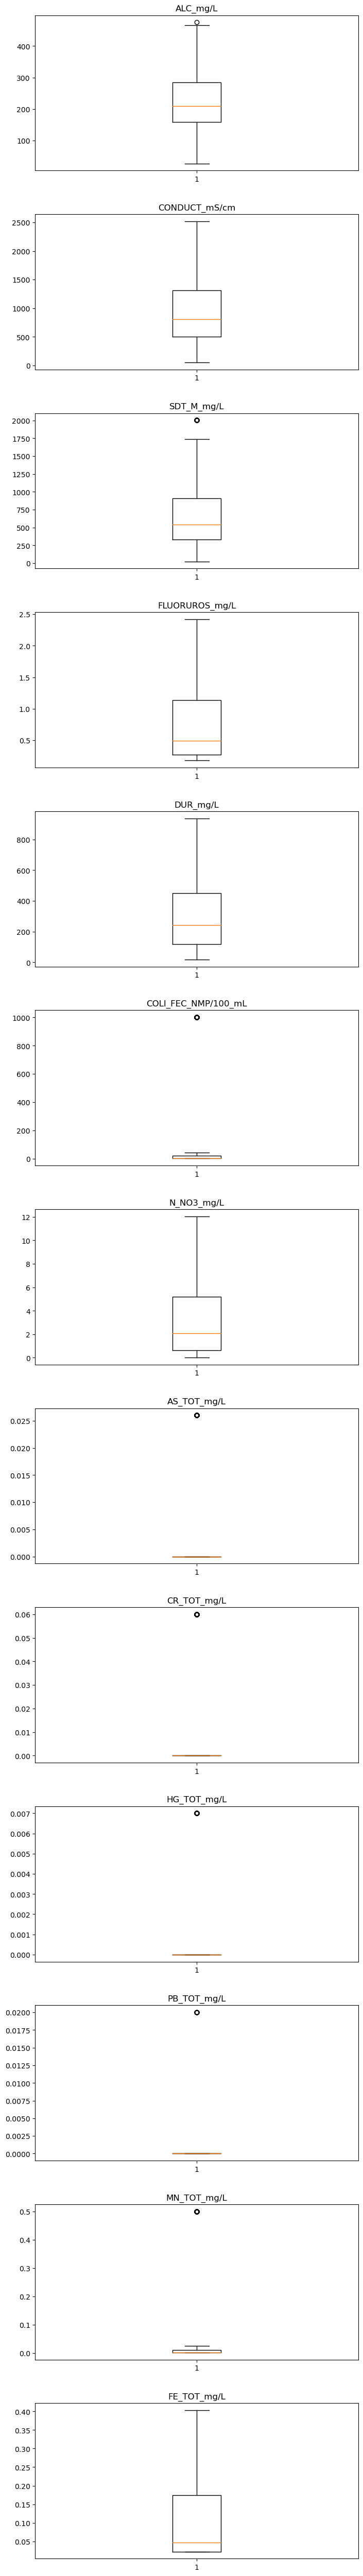

In [285]:
imp = OutlierImputer()

transf = imp.transform(X_train)

fig, axes = plt.subplots(13)
fig.set_size_inches(7,50)
plt.tight_layout(h_pad = 4)

count = 0

for i in range(13):
        axes[i].boxplot(transf[num_vars[i]].dropna())
        axes[i].set_title(num_vars[i])

De los gráficos anteriores se puede observar que el tratamiento de los atípicos mejoró el comportamiento de los datos. También se aprecia que los datos mantienen un sesgo positivo, sin embargo, esto no tiene efecto sobre el kmeans por ser un modelo paramétrico, ni en los clasificadores de árbol de decisión o bosque aleatorio.

Ahora veamos la distribución de la variable de salida.

In [286]:
(y.value_counts()/len(y)) * 100

SEMAFORO
Verde       40.636704
Rojo        36.235955
Amarillo    23.127341
dtype: float64

Del análisis anterior se evidencia que la clase 'Amarillo' se encuentra ligeramente subrepresentada. Sin embargo, una representación equitativa de cada clase equivaldría a un 33%, por lo que tampoco se encuentra muy lejos de este valor.

Para fines de este ejercicio no tomaríamos en cuenta estrategias para balanceo de clases por lo explicado arriba.

In [287]:
df.columns

Index(['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'ACUIFERO', 'SUBTIPO', 'LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L',
       'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC', 'SDT_mg/L',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L',
       'CALIDAD_FLUO', 'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL',
       'CALIDAD_COLI_FEC', 'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L',
       'CALIDAD_AS', 'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR',
       'HG_TOT_mg/L', 'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L',
       'CALIDAD_MN', 'FE_TOT_mg/L', 'CALIDAD_FE', 'SEMAFORO', 'CONTAMINANTES',
       'CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra',
       'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR',
       'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD',
       'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN',
       'CUMPLE_CON_FE'],
      dtype='

In [490]:
# df['CONTAMINANTES'] = df['CONTAMINANTES'].fillna('SIN_CONTAMINANTE')
# df.drop(['SDT_mg/L'], axis=1, inplace=True)
# na_columns.remove('SDT_mg/L')
# vars.remove('SDT_mg/L')


catImp_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
#TODO: Convertir hardness y cond en un solo imputer
custom_pipeline = Pipeline(steps=[
    ('hardness-imputer', HardnessImputer()),
     ('outlier-imputer', OutlierImputer()),
     ('scaler', MinMaxScaler())    
])  

columnasTransformer = ColumnTransformer(transformers = [
    ('catimp', catImp_pipeline, cat_vars + bin_vars),
    #('catimp',catImp_pipeline, ['LONGITUD', 'LATITUD']),
    ('custom-imp', custom_pipeline, (num_vars + ['CUMPLE_CON_COND', 'CUMPLE_CON_DUR'])),
   ],
    remainder='drop')

												
									
pipeline = Pipeline(
    steps=[
        ('ct', columnasTransformer),
       # ('outlier-transf', ColumnTransformer([ ('num-imp', numeric_pipeline, num_vars)]))
        
        ])

scaled_f = pipeline.fit_transform(df)

scaled_f[:5,:]
#scaled_f.shape, df.shape
#scaled_features_df = pd.DataFrame(scaled_f, index=df.index, columns=df.columns)

# na_columns = scaled_features_df.columns[scaled_features_df.isna().any()].tolist()
# na_total = scaled_features_df[na_columns].isna().sum()

# pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

array([[-102.0221, 22.20887, 'POZO', 'SI', 0.4529457623343357, 0.0,
        0.36022027858762556, 0.0, 0.20972484141950973,
        0.17642384105960263, 0.35562499999999997, 0.0, 0.0,
        0.34774294775496584, 0.0, 0.2937073540561031, 0.9999999999999999],
       [-102.20075, 21.99958, 'POZO', 'SI', 0.4574006014032743, 0.0,
        0.2257855523161646, 0.0, 0.17899387107834736, 0.0,
        0.3347321428571428, 0.0, 0.0, 0.4783934234685362, 0.0,
        0.21374778872883496, 0.9999999999999999],
       [-102.28801, 22.36685, 'POZO', 'SI', 0.39710435460518984, 0.0,
        0.19501133786848077, 0.0, 0.11006236070632608, 0.0,
        0.7252232142857142, 0.0, 0.0, 0.11949616090802871, 0.0,
        0.16148597422289612, 0.9999999999999999],
       [-102.29449, 22.18435, 'POZO', 'SI', 0.6690277313732041, 0.0,
        0.25736961451247165, 1.0, 0.1948814932281845, 0.0,
        0.42093749999999996, 0.0, 0.0, 0.1035383909197129, 0.0,
        0.23052817791256003, 0.9999999999999999],
       [-110.24

In [491]:
df["Coordinates"] = list(zip(df.LONGITUD, df.LATITUD))
df["Coordinates"] = df["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

In [492]:

k = 3
kmeans = KMeans(n_clusters = k, init ='k-means++')
geo_localizacion = df[['LONGITUD', 'LATITUD']]
kmeans.fit(scaled_f[:,4:])
#kmeans.fit(scaled_f)
df['labels'] = kmeans.labels_


df['labels']


0       2
1       2
2       2
3       2
4       0
       ..
1063    1
1064    1
1065    0
1066    1
1067    1
Name: labels, Length: 1068, dtype: int32

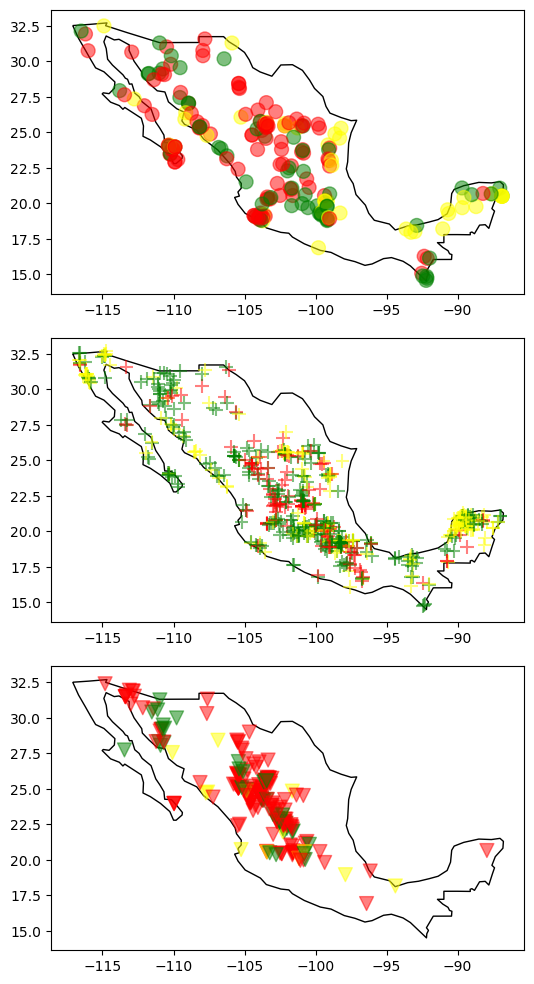

In [493]:
from pandas.core.internals.concat import concat_arrays

color_map = {
    'Verde': 'green',
    'Rojo': 'red',
    'Amarillo': 'yellow'
}

marker_map = {
    
    0: 'o',
    1: '+',
    2: 'v',
    3: '*',
    4: '<'
}

# C = kmeans.cluster_centers_
# df_centers = pd.DataFrame(C)
# df_centers["Coordinates"] = list(zip(df_centers[0], df_centers[1]))
# df_centers["Coordinates"] = df_centers["Coordinates"].apply(Point)
# geo_df = gpd.GeoDataFrame(df_centers, geometry="Coordinates") 

fig, gax = plt.subplots(k)
fig.set_size_inches(50,10)
plt.tight_layout()

for i in range(k):
    world.query("name == 'Mexico'").plot(ax = gax[i], edgecolor='black', color='white')
    gdf[gdf.labels == i].plot(ax=gax[i], color=df[gdf.labels == i].SEMAFORO.map(color_map), markersize=100, marker=marker_map[i], alpha = 0.5)


plt.show()


In [494]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
geo_localizacion = df[['LONGITUD', 'LATITUD']]
kmeans.fit(geo_localizacion)
labels = kmeans.labels_
kmeans = KMeans(n_clusters=4).fit(geo_localizacion)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(geo_localizacion)
C = kmeans.cluster_centers_
df_centers = pd.DataFrame(C)
df_centers["Coordinates"] = list(zip(df_centers[0], df_centers[1]))
df_centers["Coordinates"] = df_centers["Coordinates"].apply(Point)
geo_df = gpd.GeoDataFrame(df_centers, geometry="Coordinates") 

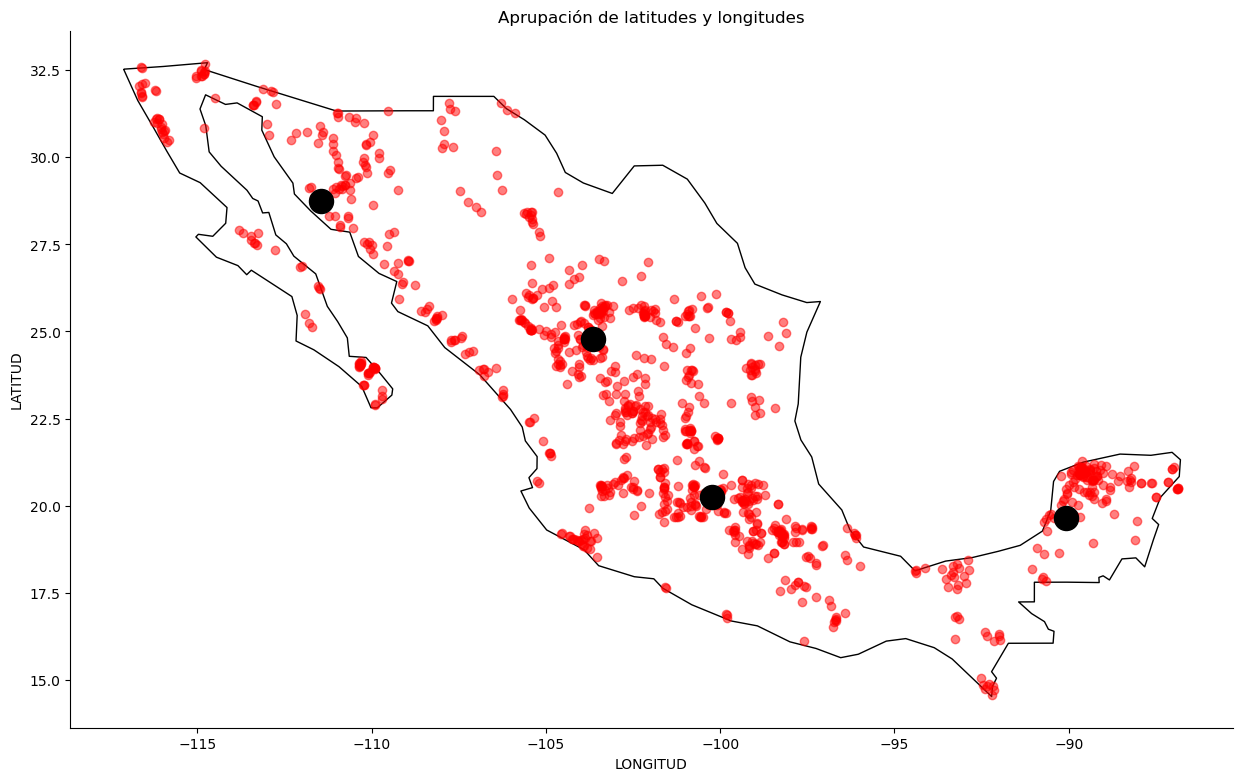

In [495]:
from pandas.core.internals.concat import concat_arrays
coord_1 = str(geo_df[1][0]) + ", " + str(geo_df[0][0])
coord_2 = str(geo_df[1][1]) + ", " + str(geo_df[0][1])
coord_3 = str(geo_df[1][2]) + ", " + str(geo_df[0][2])
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='red', alpha = 0.5)
geo_df.plot(ax=gax, color='black', alpha = 1, markersize = 300)
gax.set_xlabel('LONGITUD')
gax.set_ylabel('LATITUD')
gax.set_title('Aprupación de latitudes y longitudes')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()

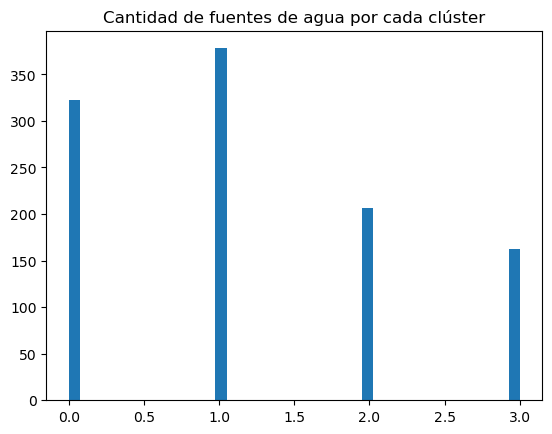

In [496]:
df_describe = pd.DataFrame(labels)
df_describe.describe()
plt.hist(labels, bins=40)  
plt.title('Cantidad de fuentes de agua por cada clúster') 
plt.show()